# BM25 vs Dense Retrieval

In [1]:
%pip install -Uq python-dotenv langchain langchain-openai langchain-pinecone kiwipiepy rank_bm25 scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['PINECONE_API_KEY'] = os.getenv("pinecone_key")

## 데이터 준비

In [17]:
import pandas as pd

documents_df = pd.read_csv('documents.csv')
queries_df = pd.read_csv('queries.csv')

queries_df

,query_id,query_text,relevant_doc_ids
0,Q1,제주도 올레길 트레킹 코스 추천,D1=3;D4=1;D30=1
1,Q2,전주 비빔밥 vs 진주 비빔밥 재료 및 맛 차이,D2=3
2,Q3,걸스데이 대표 히트곡 목록 알려줘,D3=3
3,Q4,훈민정음 창제 배경과 세종대왕의 의의,D4=3
4,Q5,이순신 장군이 명량 해전에서 사용한 전술은 무엇인가?,D5=3
5,Q6,2024년 기후 변화 주요 지표와 한국의 탄소 중립 정책,D6=3;D14=2;D26=1
6,Q7,한국 AI 윤리 이슈와 관련 정책 사례는?,D7=3;D25=2
7,Q8,서울 지하철 환승 시 T-money 사용 방법,D8=3
8,Q9,판소리 춘향가 줄거리와 공연 특징,D9=3
9,Q10,한국 축구 대표팀 2002년 한일 월드컵 4강 진출 이유,D10=3


In [4]:
documents_df

,idx,doc_id,title,content
0,0,D1,제주도 여행 가이드,"제주도는 대한민국의 대표 관광지로서, 한라산 등반, 성산 일출봉 관광, 해변 활동(..."
1,1,D2,전주 비빔밥과 진주 비빔밥 차이점,"비빔밥은 조선 시대부터 전해 내려온 대표적 한국 음식으로, 밥 위에 고명(채소·고기..."
2,2,D3,걸스데이 히트곡 분석,"걸스데이는 2010년 데뷔한 대한민국의 4인조 걸그룹으로, 대표곡으로는 “Somet..."
3,3,D4,세종대왕과 훈민정음,세종대왕(1397~1450)은 훈민정음을 창제하여 한글을 보급한 조선의 4대 임금입...
4,4,D5,이순신 장군의 명량 해전,이순신 장군(1545~1598)은 임진왜란 당시 명량 해전에서 13척의 배로 133...
5,5,D6,2024년 기후 변화 종합 보고서,"2024년 전 지구 평균 기온은 산업화 이전 대비 약 1.2℃ 상승했으며, 해수면 ..."
6,6,D7,AI 기술 동향 및 윤리,"최근 인공지능 분야에서는 생성형 AI, 멀티모달 모델, 강화학습 기반 에이전트 개발..."
7,7,D8,서울 지하철 이용 가이드,"서울 지하철은 1호선부터 9호선까지 운행되며, 주요 환승역으로는 서울역·강남역·종로..."
8,8,D9,판소리 “춘향가” 서사 구조,"판소리는 소리꾼과 고수가 함께 공연하는 한국 전통 음악으로, 대표 작품에는 “춘향가..."
9,9,D10,한국 축구 대표팀 주요 기록,"한국 축구 대표팀은 2002 한일 월드컵 4강 진출, 2012 런던 올림픽 동메달 ..."


In [5]:
documents_df.iloc[11]['content']

'서울 근교에서 당일치기로 다녀올 만한 여행지로는 가평 쁘띠프랑스, 남양주 수종사, ...'

## BM25

BM25는 **문서 집합에서 쿼리와 각 문서의 연관성 점수**를 계산하는 대표적인 키워드 기반 랭킹 알고리즘이다. 주로 정보 검색, 추천 시스템, 검색 엔진 등에서 사용된다.

- **토큰화 품질**이 BM25의 성능에 큰 영향을 미친다.
- **문서와 쿼리의 토크나이저**는 동일해야 한다.
- **점수(score)**가 높을수록 쿼리와 문서의 연관성이 높다.


**주요 메소드**

| 메소드                       | 설명                                         |
|-----------------------------|----------------------------------------------|
| `BM25Okapi(tokenized_corpus)` | 토큰화된 문서 집합으로 BM25 모델 생성        |
| `get_scores(tokenized_query)` | 쿼리에 대해 각 문서의 BM25 점수 반환         |
| `get_top_n(tokenized_query, corpus, n)` | 점수 기준 상위 n개 문서 반환      |


**파라미터 설명**

- **k1**: 단어 빈도(TF)에 대한 가중치 (기본값: 1.5)
- **b**: 문서 길이 보정 파라미터 (기본값: 0.75)
- **epsilon**: 음수 IDF 방지 하한값 (기본값: 0.25)
- 파라미터는 BM25Okapi 생성 시 지정 가능하다.

**BM25 기본 공식**

BM25는 **쿼리 Q와 문서 D의 관련성 점수**를 다음 공식으로 계산한다:

$$
\text{score}(D, Q) = \sum_{i=1}^{n} \text{IDF}(q_i) \cdot \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot \left(1 - b + b \cdot \frac{|D|}{\text{avgdl}}\right)}
$$

여기서:
- $q_i$: 쿼리의 i번째 단어
- $f(q_i, D)$: 문서 D에서 $q_i$의 등장 횟수 (TF)
- $|D|$: 문서 D의 길이 (단어 수)
- $\text{avgdl}$: 전체 문서 집합의 평균 길이
- $k_1$, $b$: 조정 파라미터 (기본값: $k_1=1.5$, $b=0.75$) *BM25Okapi방식의 기본값*


**TF-IDF와 BM25의 결정적 차이: 포화도(Saturation)**

TF-IDF에서는 단어 빈도(TF)가 증가함에 따라 점수가 선형적으로 계속해서 높아진다. 하지만 BM25는 단어 빈도가 높아질수록 점수가 수렴하는 곡선을 그린다.

비유: 배가 고플 때 빵을 한 개 먹으면 매우 만족스럽지만, 10개째 먹을 때는 첫 번째만큼의 만족감을 주지 못하는 것과 같다. BM25는 이러한 '한계 효용 체감'의 원리를 계산식에 반영한다.


**`rank_bm25.BM25Okapi`**

rank_bm25 패키지는 BM25 알고리즘의 여러 변형을 제공하며, 그중 가장 널리 쓰이는 방식인 Okapi BM25를 구현한 클래스가 바로 BM25Okapi이다.

1980년대와 90년대에 런던 시티 대학교의 Okapi 정보 검색 시스템에서 처음 구현되었기에 이 이름이 붙었다

| 모델 | 주요 목적 | 특징 |
| --- | --- | --- |
| **BM25Okapi** | 표준 검색 알고리즘 | 가장 널리 쓰이며 일반적인 상황에서 우수함. |
| **BM25L** | 긴 문서 페널티 보정 | 문서 길이가 매우 길 때 발생하는 점수 왜곡을 방지함. |
| **BM25Plus** | 최소 점수 보장 | 문서 길이에 상관없이 키워드 존재에 대한 최소 가중치를 부여함. |

사용 중인 데이터셋의 문서 길이가 매우 길거나 불균형하다면 `BM25L`이나 `BM25Plus`를 적용해 성능을 비교해 보는 것이 좋다.


In [6]:
# kiwi 형태소분석기
from kiwipiepy import Kiwi

kiwi = Kiwi()

doc = documents_df['content'][0]
print(doc)

tokens = kiwi.tokenize(doc)
display(tokens)
tokens = [token.form for token in tokens]
print(tokens)

제주도는 대한민국의 대표 관광지로서, 한라산 등반, 성산 일출봉 관광, 해변 활동(...


[Token(form='제주도', tag='NNP', start=0, len=3),
 Token(form='는', tag='JX', start=3, len=1),
 Token(form='대한민국', tag='NNP', start=5, len=4),
 Token(form='의', tag='JKG', start=9, len=1),
 Token(form='대표', tag='NNG', start=11, len=2),
 Token(form='관광지', tag='NNG', start=14, len=3),
 Token(form='로서', tag='JKB', start=17, len=2),
 Token(form=',', tag='SP', start=19, len=1),
 Token(form='한라산', tag='NNP', start=21, len=3),
 Token(form='등반', tag='NNG', start=25, len=2),
 Token(form=',', tag='SP', start=27, len=1),
 Token(form='성산', tag='NNP', start=29, len=2),
 Token(form='일출봉', tag='NNP', start=32, len=3),
 Token(form='관광', tag='NNG', start=36, len=2),
 Token(form=',', tag='SP', start=38, len=1),
 Token(form='해변', tag='NNG', start=40, len=2),
 Token(form='활동', tag='NNG', start=43, len=2),
 Token(form='(', tag='SSO', start=45, len=1),
 Token(form='...', tag='SF', start=46, len=3)]

['제주도', '는', '대한민국', '의', '대표', '관광지', '로서', ',', '한라산', '등반', ',', '성산', '일출봉', '관광', ',', '해변', '활동', '(', '...']


In [7]:
# BM25 키워드 검색 모델
# - 문서를 토큰화해서 BM25모델 생성
# - 검색어도 동일하게 토큰화한 이후 BM25 검색

from rank_bm25 import BM25Okapi
from kiwipiepy import Kiwi

def kiwi_tokenize(doc):
    return [token.form for token in kiwi.tokenize(doc)]

tokenized_docs = [kiwi_tokenize(doc) for doc in documents_df['content']]
bm25 = BM25Okapi(tokenized_docs)

def bm25_search(query, top_k=5):
    query_tokens = kiwi_tokenize(query)
    # print(query_tokens)
    scores = bm25.get_scores(query_tokens) # 30개의 문서에 대한 bm25 점수
    # print(scores)

    ranked_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    retrieved_docs = [documents_df['doc_id'].iloc[i] for i in ranked_idx[:top_k]]
    return retrieved_docs

bm25_search('제주도 관광 명소')

['D1', 'D2', 'D3', 'D4', 'D5']

## 벡터 서치

In [8]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embedding_model = OpenAIEmbeddings()
vector_store = PineconeVectorStore(
    index_name='ir',
    embedding=embedding_model
 )

c:\Users\user\nlp\natural_language_processing\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 검색성능 평가

**평가지표 설명**

* **Precision\@k**: 상위 k개의 검색 결과 중에 진짜 필요한 문서가 얼마나 있는지를 측정한다.
  - 예컨대 k=5일 때, 결과 5개 중 관련 문서가 2개면 Precision\@5 = 2/5 = 0.4다.

* **Recall\@k**: 전체 관련 문서 중에서 상위 k개 안에 얼마나 많이 들어왔는지를 본다.
  - 예컨대 전체 관련 문서가 4개이고, 그중 3개가 상위 5개 안에 들어오면 Recall\@5 = 3/4 = 0.75다.


* **MRR (Mean Reciprocal Rank)**:
  사용자가 제시한 여러 질의에서, 각 질의별로 “첫 번째 관련 문서”가 나온 순위의 역수를 구한 뒤 평균낸 것이다.
  **예시**

  * 질의 A: 첫 관련 문서가 2위 → RR = 1/2 = 0.5
  * 질의 B: 첫 관련 문서가 3위 → RR = 1/3 ≈ 0.333
  * 질의 C: 첫 관련 문서가 1위 → RR = 1/1 = 1
  * 이 세 질의의 MRR = (0.5 + 0.333 + 1) / 3 ≈ 0.611

* **AP (Average Precision)**:
  한 질의 결과 리스트를 순서대로 훑어가며, 관련 문서를 만날 때마다 그 시점까지의 Precision을 계산한 뒤, 관련 문서 개수로 나눈 값이다.
  **예시** (관련 문서 3개가 있고, 순위 2, 4, 5위에 위치한 경우)

  1. 2위에서 첫 관련 문서 발견 → Precision\@2 = 1/2 = 0.50
  2. 4위에서 두 번째 관련 문서 발견 → Precision\@4 = 2/4 = 0.50
  3. 5위에서 세 번째 관련 문서 발견 → Precision\@5 = 3/5 = 0.60
     AP = (0.50 + 0.50 + 0.60) / 3 ≈ 0.533

In [9]:
import numpy as np

# 참조문서 답안 파싱
def parse_relevant(relevant_str) -> dict[str, int]:
    """
    relevant_str = 'D1=3;D4=1;D30=1' -> {'D1': 3, 'D4': 1, 'D30': 1}
    """
    pairs = relevant_str.split(';')
    rel_dict = {}
    for pair in pairs:
        doc_id, grade = pair.split('=')
        rel_dict[doc_id] = int(grade)
    return rel_dict


# 평가지표 계산
def compute_metrics(predicted, relevant_dict, k=5) -> tuple[float, float, float, float]:
    # Precision@k
    hits = sum([1 for doc in predicted[:k] if doc in relevant_dict])
    precision = hits / k

    # Recall@k
    total_relevant = len(relevant_dict) # {'D1': 3, 'D12': 2, ...}
    recall = hits / total_relevant if total_relevant > 0 else 0

    # MRR 예측치중 첫 관련문서 순위점수
    rr = 0
    for idx, doc in enumerate(predicted):
        if doc in relevant_dict:
            rr = 1 / (idx + 1)
            break

    # AP(MAP를 위한 계산)
    num_correct = 0
    precisions = []
    for idx, doc in enumerate(predicted[:k]):
        if doc in relevant_dict:
            num_correct += 1
            precisions.append(num_correct / (idx + 1))
    ap = np.mean(precisions) if precisions else 0
    return precision, recall, rr, ap


# 평가함수
def evaluate_all(method_results, queries_df, k=5):
    prec_list, rec_list, rr_list, ap_list = [], [], [], []

    for idx, row in queries_df.iterrows():
        qid = row['query_id']
        relevant_dict = parse_relevant(row['relevant_doc_ids'])
        predicted = method_results[qid]
        p, r, rr, ap = compute_metrics(predicted, relevant_dict, k)
        prec_list.append(p)
        rec_list.append(r)
        rr_list.append(rr)
        ap_list.append(ap)

    return {
        'P@k': np.mean(prec_list),
        'R@k': np.mean(rec_list),
        'MRR': np.mean(rr_list),
        'MAP': np.mean(ap_list),
    }


## BM25 | Vector검색 수행

In [10]:
bm25_results = {}
for idx, row in queries_df.iterrows():
    qid = row['query_id']
    query_text = row['query_text']
    bm25_results[qid] = bm25_search(query_text, top_k=5)
bm25_results

{'Q1': ['D1', 'D2', 'D3', 'D4', 'D5'],
 'Q2': ['D13', 'D2', 'D1', 'D3', 'D4'],
 'Q3': ['D2', 'D21', 'D14', 'D11', 'D28'],
 'Q4': ['D4', 'D9', 'D1', 'D30', 'D5'],
 'Q5': ['D5', 'D18', 'D19', 'D23', 'D15'],
 'Q6': ['D6', 'D27', 'D17', 'D25', 'D3'],
 'Q7': ['D27', 'D25', 'D7', 'D14', 'D9'],
 'Q8': ['D8', 'D18', 'D30', 'D12', 'D29'],
 'Q9': ['D9', 'D27', 'D1', 'D2', 'D3'],
 'Q10': ['D10', 'D3', 'D9', 'D17', 'D25'],
 'Q11': ['D11', 'D4', 'D14', 'D28', 'D26'],
 'Q12': ['D12', 'D8', 'D9', 'D27', 'D5'],
 'Q13': ['D13', 'D14', 'D26', 'D2', 'D3'],
 'Q14': ['D14', 'D7', 'D25', 'D27', 'D26'],
 'Q15': ['D9', 'D15', 'D26', 'D14', 'D1'],
 'Q16': ['D16', 'D15', 'D9', 'D29', 'D8'],
 'Q17': ['D17', 'D25', 'D6', 'D3', 'D10'],
 'Q18': ['D18', 'D4', 'D28', 'D5', 'D7'],
 'Q19': ['D19', 'D18', 'D14', 'D24', 'D29'],
 'Q20': ['D20', 'D27', 'D10', 'D3', 'D4'],
 'Q21': ['D21', 'D19', 'D25', 'D2', 'D11'],
 'Q22': ['D22', 'D7', 'D23', 'D19', 'D18'],
 'Q23': ['D23', 'D26', 'D24', 'D22', 'D19'],
 'Q24': ['D24', 'D23

In [11]:
dense_results = {}
for idx, row in queries_df.iterrows():
    qid = row['query_id']
    query_text = row['query_text']
    docs = vector_store.similarity_search(query_text, k=5)
    dense_results[qid] = [doc.metadata['doc_id'] for doc in docs]
dense_results

{'Q1': ['D12', 'D1', 'D8', 'D26', 'D17'],
 'Q2': ['D13', 'D2', 'D16', 'D12', 'D5'],
 'Q3': ['D3', 'D9', 'D17', 'D15', 'D12'],
 'Q4': ['D4', 'D5', 'D1', 'D9', 'D2'],
 'Q5': ['D5', 'D4', 'D15', 'D2', 'D16'],
 'Q6': ['D6', 'D25', 'D26', 'D17', 'D1'],
 'Q7': ['D25', 'D7', 'D14', 'D26', 'D10'],
 'Q8': ['D8', 'D12', 'D15', 'D26', 'D4'],
 'Q9': ['D9', 'D15', 'D1', 'D3', 'D12'],
 'Q10': ['D10', 'D4', 'D1', 'D3', 'D5'],
 'Q11': ['D11', 'D2', 'D13', 'D1', 'D12'],
 'Q12': ['D12', 'D1', 'D8', 'D10', 'D4'],
 'Q13': ['D13', 'D2', 'D11', 'D16', 'D26'],
 'Q14': ['D14', 'D26', 'D7', 'D25', 'D6'],
 'Q15': ['D15', 'D16', 'D9', 'D4', 'D1'],
 'Q16': ['D16', 'D9', 'D2', 'D4', 'D5'],
 'Q17': ['D17', 'D25', 'D3', 'D10', 'D1'],
 'Q18': ['D18', 'D4', 'D26', 'D20', 'D10'],
 'Q19': ['D19', 'D23', 'D20', 'D24', 'D22'],
 'Q20': ['D20', 'D18', 'D12', 'D16', 'D19'],
 'Q21': ['D21', 'D23', 'D18', 'D26', 'D15'],
 'Q22': ['D22', 'D23', 'D24', 'D20', 'D19'],
 'Q23': ['D23', 'D24', 'D22', 'D20', 'D26'],
 'Q24': ['D24', 'D

In [12]:
# bm25 검색결과
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(bm25_results, columns=bm25_results.keys())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
0,D1,D13,D2,D4,D5,D6,D27,D8,D9,D10,D11,D12,D13,D14,D9,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30
1,D2,D2,D21,D9,D18,D27,D25,D18,D27,D3,D4,D8,D14,D7,D15,D15,D25,D4,D18,D27,D19,D7,D26,D23,D9,D14,D30,D27,D12,D4
2,D3,D1,D14,D1,D19,D17,D7,D30,D1,D9,D14,D9,D26,D25,D26,D9,D6,D28,D14,D10,D25,D23,D24,D22,D17,D7,D1,D30,D22,D29
3,D4,D3,D11,D30,D23,D25,D14,D12,D2,D17,D28,D27,D2,D27,D14,D29,D3,D5,D24,D3,D2,D19,D22,D19,D3,D5,D2,D1,D28,D25
4,D5,D4,D28,D5,D15,D3,D9,D29,D3,D25,D26,D5,D3,D26,D1,D8,D10,D7,D29,D4,D11,D18,D19,D3,D8,D29,D3,D2,D30,D14


In [13]:
# dense 검색결과
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(dense_results, columns=dense_results.keys())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
0,D12,D13,D3,D4,D5,D6,D25,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D7
1,D1,D2,D9,D5,D4,D25,D7,D12,D15,D4,D2,D1,D2,D26,D16,D9,D25,D4,D23,D18,D23,D23,D24,D23,D7,D14,D29,D29,D30,D4
2,D8,D16,D17,D1,D15,D26,D14,D15,D1,D1,D13,D8,D11,D7,D9,D2,D3,D26,D20,D12,D18,D24,D22,D22,D17,D7,D30,D30,D27,D30
3,D26,D12,D15,D9,D2,D17,D26,D26,D3,D3,D1,D10,D16,D25,D4,D4,D10,D20,D24,D16,D26,D20,D20,D19,D14,D28,D26,D26,D7,D25
4,D17,D5,D12,D2,D16,D1,D10,D4,D12,D5,D12,D4,D26,D6,D1,D5,D1,D10,D22,D19,D15,D19,D26,D20,D26,D29,D28,D27,D26,D5


## 성능평가

In [14]:
bm25_metrics = evaluate_all(bm25_results, queries_df, k=5)
dense_metrics = evaluate_all(dense_results, queries_df, k=5)

In [15]:
import pandas as pd
metrics_df = pd.DataFrame({
    'Metrics': ['P@5', 'R@5', 'MRR', 'MAP'],
    'BM25': [bm25_metrics['P@k'], bm25_metrics['R@k'], bm25_metrics['MRR'], bm25_metrics['MAP']],
    'Dense': [dense_metrics['P@k'], dense_metrics['R@k'], dense_metrics['MRR'], dense_metrics['MAP']]
})
metrics_df


,Metrics,BM25,Dense
0,P@5,0.233333,0.273333
1,R@5,0.838889,0.950000
2,MRR,0.900000,0.966667
3,MAP,0.874444,0.930556


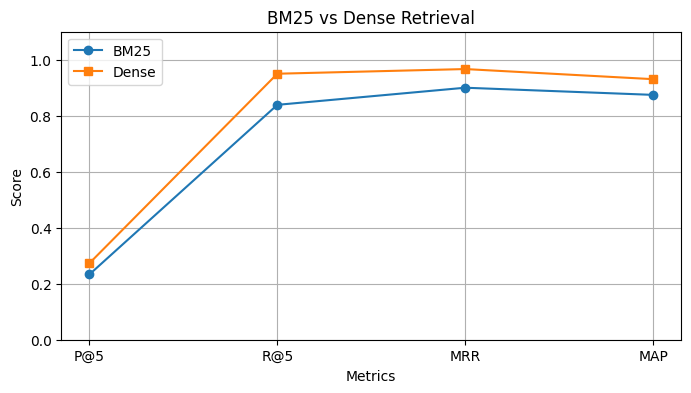

In [16]:
# 시각화
import matplotlib.pyplot as plt

metrics = ['P@5', 'R@5', 'MRR', 'MAP']
bm25_vals = [bm25_metrics['P@k'], bm25_metrics['R@k'], bm25_metrics['MRR'], bm25_metrics['MAP']]
dense_vals = [dense_metrics['P@k'], dense_metrics['R@k'], dense_metrics['MRR'], dense_metrics['MAP']]

x = range(len(metrics))

plt.figure(figsize=(8, 4))
plt.plot(x, bm25_vals, marker='o', label='BM25')
plt.plot(x, dense_vals, marker='s', label='Dense')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('BM25 vs Dense Retrieval')
plt.legend()
plt.grid()
plt.show()



- 지표해석
    - **P@5 (Precision@5)**
        - **Dense > BM25**
        - 상위 5개 결과 중 **정답 비율**이 Dense가 더 높음
            
            → *사용자 입장에서 “위에 뜬 게 바로 쓸만한가?”에는 Dense가 유리*
            
    - **R@5 (Recall@5)**
        - **Dense > BM25 (차이 꽤 큼)**
        - 관련 문서를 **얼마나 놓치지 않고 찾아냈는지 →** Dense가 의미 기반이라 **동의어·표현 변형에 강함**
    - **MRR**
        - **Dense > BM25**
        - **첫 번째 정답이 얼마나 앞에 나오느냐** → Dense는 정답을 **더 빨리(상위에)** 가져옴
    - **MAP**
        - **Dense > BM25**
        - 랭킹 전체 품질을 종합적으로 보는 지표 → Dense가 **정렬 품질 자체가 더 좋음**
    
    | 상황 | 더 유리한 방식 |
    | --- | --- |
    | 키워드가 정확 | BM25 |
    | 짧은 문서, 명확한 용어 | BM25 |
    | 의미/문맥 검색 | **Dense** |
    | 질문형·자연어 쿼리 | **Dense** |
    | 실제 서비스 | **Hybrid(BM25 + Dense)** |